# BayesEoR Matrix Normalization Walkthrough

This document outlines the matrix and power spectrum normalizations currently in place on the `a_in_mK_sr_Hz` branch of `BayesEoR`.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Fourier-Transform-Conventions" data-toc-modified-id="Fourier-Transform-Conventions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Fourier Transform Conventions</a></span></li><li><span><a href="#Useful-BayesEoR-Parameter-Definitions" data-toc-modified-id="Useful-BayesEoR-Parameter-Definitions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Useful BayesEoR Parameter Definitions</a></span></li><li><span><a href="#Matrix-Normalization-Testing-Process" data-toc-modified-id="Matrix-Normalization-Testing-Process-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Matrix Normalization Testing Process</a></span><ul class="toc-item"><li><span><a href="#Master-Branch-Normalizations" data-toc-modified-id="Master-Branch-Normalizations-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Master Branch Normalizations</a></span></li><li><span><a href="#Units-Branch-Normalizations" data-toc-modified-id="Units-Branch-Normalizations-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Units Branch Normalizations</a></span></li><li><span><a href="#Matrix-Normalization-Test-Outline" data-toc-modified-id="Matrix-Normalization-Test-Outline-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Matrix Normalization Test Outline</a></span></li></ul></li><li><span><a href="#Power-Spectrum-Normalization-Testing-Process" data-toc-modified-id="Power-Spectrum-Normalization-Testing-Process-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Power Spectrum Normalization Testing Process</a></span><ul class="toc-item"><li><span><a href="#Power-Spectrum-Normalization-Test-Outline" data-toc-modified-id="Power-Spectrum-Normalization-Test-Outline-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Power Spectrum Normalization Test Outline</a></span></li></ul></li><li><span><a href="#BayesEoR-Power-Spectra" data-toc-modified-id="BayesEoR-Power-Spectra-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>BayesEoR Power Spectra</a></span><ul class="toc-item"><li><span><a href="#Internal-Model-Tests" data-toc-modified-id="Internal-Model-Tests-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Internal Model Tests</a></span></li><li><span><a href="#$\texttt{healvis}$-Simulated-Datasets" data-toc-modified-id="$\texttt{healvis}$-Simulated-Datasets-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>$\texttt{healvis}$ Simulated Datasets</a></span></li><li><span><a href="#Internal-Model-and-$\texttt{healvis}$-Visibilities-Comparison" data-toc-modified-id="Internal-Model-and-$\texttt{healvis}$-Visibilities-Comparison-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Internal Model and $\texttt{healvis}$ Visibilities Comparison</a></span><ul class="toc-item"><li><span><a href="#Time-Evolution-of-the-Sky-Model" data-toc-modified-id="Time-Evolution-of-the-Sky-Model-5.3.1"><span class="toc-item-num">5.3.1&nbsp;&nbsp;</span>Time Evolution of the Sky Model</a></span></li><li><span><a href="#Pixel-Area-Comparison" data-toc-modified-id="Pixel-Area-Comparison-5.3.2"><span class="toc-item-num">5.3.2&nbsp;&nbsp;</span>Pixel Area Comparison</a></span></li><li><span><a href="#Sky-Model-Standard-Deviation-Comparison" data-toc-modified-id="Sky-Model-Standard-Deviation-Comparison-5.3.3"><span class="toc-item-num">5.3.3&nbsp;&nbsp;</span>Sky Model Standard Deviation Comparison</a></span></li></ul></li><li><span><a href="#BayesEoR-Power-Spectrum-Tests" data-toc-modified-id="BayesEoR-Power-Spectrum-Tests-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>BayesEoR Power Spectrum Tests</a></span><ul class="toc-item"><li><span><a href="#Different-Sky-Noise-Seeds" data-toc-modified-id="Different-Sky-Noise-Seeds-5.4.1"><span class="toc-item-num">5.4.1&nbsp;&nbsp;</span>Different Sky Noise Seeds</a></span></li><li><span><a href="#Different-BayesEoR-Sky-Model-Resolutions" data-toc-modified-id="Different-BayesEoR-Sky-Model-Resolutions-5.4.2"><span class="toc-item-num">5.4.2&nbsp;&nbsp;</span>Different BayesEoR Sky Model Resolutions</a></span></li></ul></li></ul></li></ul></div>

In [1]:
%cd /users/jburba/data/jburba/bayes/BayesEoR/
%matplotlib inline

import multiprocessing, os
CPU_AVAIL = int(multiprocessing.cpu_count())
os.environ["MKL_NUM_THREADS"] = str(CPU_AVAIL-1)

import sys
import collections
import numpy as np
import h5py
import glob
import pickle

from scipy.linalg import block_diag
from astropy.time import Time
from scipy import sparse
from astropy import constants
from BayesEoR.Utils import Cosmology

from mn_ps_plotting_tools import *

# Load k values
k_vals_path = 'k_vals/k_vals_nu_9_nv_9_nf_38_nq_0_binning_v2d1.txt'
k_vals = np.array(np.genfromtxt(k_vals_path))
log_k_vals = np.log10(k_vals)

/gpfs/data/jpober/jburba/bayes/BayesEoR
Hi! 66.9547002601 0.669547002601
Computing on GPU


In [3]:
rcParams.update({'font.size': 12, 'figure.figsize':(12, 8)})

## Fourier Transform Conventions

<a id="ftconv"></a>
The forward and reverse transforms used here for an lmf cube $\mathbf{I}(l, m , f)$ are defined as

\begin{align}
    \rm{Forward}&:&\ 
        \tilde{\mathbf{I}}(u, v, \eta) &= \mathcal{F}_{3D}\mathbf{I}(l, m, f)\cdot\rm{d}V \\[5pt]
    \rm{Inverse}&:&\ 
        \mathbf{I}(l, m, f) &= \mathbf{F'}\mathbf{F_z}\;\tilde{\mathbf{I}}(u, v, \eta)\cdot\rm{d}\tilde{V}
\end{align}

where $\mathcal{F}_{3D}$ is the 3D $\texttt{numpy.fft}$ fast Fourier transform, and $\mathbf{F_z}$ and $\mathbf{F'}$ are BayesEoR uniform IDFT matrices which take you from $uv\eta\rightarrow uvf$ and $uvf\rightarrow lmf$ coordinates, respectively.  

$\mathbf{F'}$ and $\mathbf{F_z}$ differ from the $\texttt{numpy.fft.ifft2}$ and $\texttt{numpy.fft.ifft}$ routines, respectively, in two ways.  First, the choice of normalization is different.  Where $\texttt{numpy.fft}$ uses a $\rm{N}_{\rm{pix}}^{-1}$ normalization for the inverse transform only, we instead use the above convention with $\rm{d}V$ in units of sr Hz and $\rm{d}\tilde{V}$ in units of sr$^{-1}$ Hz$^{-1}$ for the forward and reverse transforms, respectively.  Second, unlike the $\texttt{numpy.fft.ifft2}$ function, $\mathbf{F}'$ <i>contains no monopole term</i>, i.e. $(u, v) = (0, 0)$ is excluded from $\mathbf{F}'$.

Using these conventions, the total power contained in a cube is given by the sum of the amplitudes of the pixels squared times the respective pixel volume, i.e.

\begin{align}
P[\mathbf{I}(l, m, f)] &= \sum_{l, m, f} \mathbf{I}^2(l, m, f)\;\rm{d}V\\[5pt]
P[\tilde{\mathbf{I}}(u, v, \eta)] &= \sum_{u, v, \eta} |\tilde{\mathbf{I}}(u, v, \eta)|^2\;\rm{d}\tilde{V}  \\[5pt]
\end{align}

## Useful BayesEoR Parameter Definitions

<a id="params"></a>
The BayesEoR model is constructed using the following relevant parameters:

| Parameter$\qquad$ | Description 
|:-- | :--
| $\rm{nx},\,\rm{ny}$ | number of pixels on a side for the rectilinear sky model ($\rm{nx}=\rm{ny}$)
| $\rm{nu},\,\rm{nv}$ | number of pixels on a side for the rectilinear uv model ($\rm{nu}=\rm{nv}$)
| $\rm{nf}$           | number of frequencies (line of sight, LoS, dimension)
| $\rm{n}\eta$        | number of line of sight Fourier transform parameters
| $\rm{FoV}$          | field of view of the rectilinear sky model
| $B$                 | bandwidth

The following parameters are derived using these definitions:

| Term$\qquad$ | Description$\qquad$ | Definition | Units$\quad$
|:-- | :-- | :-- | :--
| $\rm{d}l$, $\rm{d}m$  | pixel side length       | $\rm{FoV}\,/\,nx$ | $\rm{rad}$
| $\rm{d}u$, $\rm{d}v$  | uv pixel side length    | $1\,/\,\rm{FoV}$  | $\rm{rad}^{-1}$
| $\rm{d}f$                | frequency channel width | $B\,/\,\rm{nf}$   | $\rm{Hz}$
| $\rm{d}\eta$             | LoS dual channel width  | $1\,/\,B$  | $\rm{Hz}^{-1}$

Because $\rm{nx}=\rm{ny}$ and the FoV is the same in the $l$ and $m$ directions, it is also true that $\rm{d}l = \rm{d}m$ and $\rm{d}u = \rm{d}v$.

## Matrix Normalization Testing Process

If the matrices are normalized correctly, in whatever choice of units, the power should be conserved in the forward and reverse transforms, relative to the power in the initial $lmf$ cube.  The normalizations for the two branches and the $\rm{d}V$ and $\rm{d}\tilde{V}$ terms for the two branches are defined in the following subsections.

<h3>Master Branch Normalizations</h3>
    
The master branch has no physical units in front of the IDFT matrices, only pixel related normalizations:

| Matrix$\quad$ | Normalization | $\quad$Units$\quad$
|:-- | :-: | :-:
| $\mathbf{F}'$  | $(\rm{nu\,nv})^{-1}$ | -
| $\mathbf{F_z}$ | $\rm{n}\eta^{-1/2}$  | -

Here, $\rm{d}V=1$ and $\rm{d}\tilde{V} = (\rm{nu\,nv\,}\sqrt{\rm{n}\eta})^{-1}$.

<h3>Units Branch Normalizations</h3>
    
The units branch has the following normalizations in physical units in front of the IDFT matrices:

| Matrix$\quad$ | Normalization | $\quad$Units$\quad$          
| :-- | :-: | :-: 
| $\mathbf{F}'$  | $\rm{d}u\,\rm{d}v\ =\ \rm{FoV}^{-2}$    | $\rm{sr}^{-1}$ 
| $\mathbf{F_z}$ | $\rm{d}\eta = B^{-1}$                     | $\rm{Hz}^{-1}$ 

Here, $\rm{d}V = \rm{d}l\,\rm{d}m\,\rm{d}f$ and $\rm{d}\tilde{V} = \rm{d}u\,\rm{d}v\,\rm{d}\eta$ with $\rm{FoV}$ the field of view and $B$ the bandwidth.

### Matrix Normalization Test Outline

Using the definition outlines above for the forward transform, the process used for validating the appropriate BayesEoR matrix normalizations on the two separate branches as follows:
  1. Create a white noise cube $\mathbf{I}(l, m, f)$ with the following properties:
      * $(\mu, \sigma) = (0, 6.3797684)$ in units of mK
      * $\rm{FoV} = 12 \cdot \pi\,/\,180$ is the field of view (12$^\circ$on a side) in radians
      * $B = 7.6$ MHz is the bandwidth
      * Shape $(\rm{nf,\ ny,\ nx}) = (\rm{38,\ 9,\ 9})$:
        - 38 frequency channels with a spacing $\rm{d}f=200$ kHz
        - 9 pixels on a side with a resolution of $\rm{d}l=\rm{d}m=\rm{FoV}/nx\sim0.023\ \rm{rad}$
        
  2. Compute the power contained in $\mathbf{I}(l, m, f)$, i.e. $P[\mathbf{I}(l, m, f)]$.
  
  3. Compute the 3DFFT of this white noise cube using the $\texttt{numpy.fft.fftn}$ function to get an unnormalized uv$\eta$ cube, $\tilde{\mathbf{I}}'(u, v, \eta)$.  The prime here indicates that this uv$\eta$ cube is in units of $\rm{mK}$ only, not in physical units of $\rm{mK\, sr\, Hz}$.  Note that the forward 3DFFT of the $lmf$ cube will result in a $uv\eta$ model with the same shape of $(\rm{n}\eta,\ \rm{nv},\ \rm{nu}) = (38, 9, 9)$.
  
  4. Multiply $\tilde{\mathbf{I}}'(u, v, \eta)$ by $\rm{d}V$ to get $\tilde{\mathbf{I}}(u, v, \eta) = \tilde{\mathbf{I}}'(u, v, \eta)\cdot\rm{d}V$, a uv$\eta$ cube in $\rm{mK}$ or $\rm{mK\, sr\, Hz}$ for the master and units branches, respectively.
  
  5. Compute the power contained in $\tilde{\mathbf{I}}(u, v, \eta)$, i.e. $P[\tilde{\mathbf{I}}(u, v, \eta)]$.
  
  6. Get a model lmf cube from $\tilde{\mathbf{I}}(u, v, \eta)$ via $\mathbf{I_{\rm{model}}}(l, m, f) = \mathbf{F}'\,\mathbf{F_z}\,\tilde{\mathbf{I}}(u, v, \eta)$.
  
  7. Compute the power in the model lmf cube, i.e. $P[\mathbf{I_{\rm{model}}}(l, m, f)]$
    
  8. Check that $P[\mathbf{I}(l, m, f)] \;=\; P[\tilde{\mathbf{I}}(u, v, \eta)] \;=\;  P[\mathbf{I_{\rm{model}}}(l, m, f)]$.

If step 8 is satisfied, then the matrices are normalized correctly.

This test and the corresponding steps are detailed in the following function.

In [18]:
def power_conservation_comparison(params, array_save_directory): 
    # Load in matrices from BayesEoR
    master_Fprime_Fz = h5py.File(os.path.join(array_save_directory['master'],
                                              'Fprime_Fz.h5'),
                                 'r')['Fprime_Fz'][:]
    units_Fprime_Fz = h5py.File(os.path.join(array_save_directory['units'],
                                             'Fprime_Fz.h5'),
                                'r')['Fprime_Fz'][:]
    
    # Params
    nf, nq = params['nf'], params['nq']
    nx, ny = params['nx'], params['ny']
    nu, nv = nx, ny
    nuv = nu * nv - 1
    print('Params:\n' + '-' * len('Params:'))
    print('nf, nq = {}, {}'.format(nf, nq))
    print('nx, ny = {}, {}\n'.format(nx, ny))
    
    if params['rescale_master']:
        master_Fprime_Fz /= np.sqrt(nf)

    # lmf space volume params
    df_Hz = params['df_Hz']
    fov_deg = params['fov_deg']
    dl_rad = np.deg2rad(fov_deg / nx)
    dV_sr_Hz = dl_rad**2 * df_Hz

    # uveta space volume params
    du_irad = 1.0 / np.deg2rad(fov_deg)
    deta_iHz = 1.0 / (nf * df_Hz)
    dV_isr_iHz = du_irad**2 * deta_iHz


    ### STEP 1
    """ Create the white noise sky realization """
    rms_mK = 6.3797684
    np.random.seed(71234)
    lmf_cube = np.random.normal(0, rms_mK, (nf, ny, nx))

    # Fprime contains no monopole term, so the white
    # noise realization must be zero mean per channel
    # for the information content to be conserved.
    for i_f in range(nf):
        lmf_cube[i_f] -= lmf_cube[i_f].mean()

    print('lmf cube:\n' + '-' * len('lmf cube:'))
    print('Shape = (nf, ny, nx) = {}'.format(lmf_cube.shape))
    print('Mean = {} mK'.format(lmf_cube.mean()))
    print('RMS  = {} mK\n'.format(lmf_cube.std()))


    ### STEP 2
    """ Compute the power in the lmf cube """
    lmf_cube_power = np.sum(lmf_cube**2) * dV_sr_Hz


    ### STEP 3
    """ Forward FFT (using np.fft.fftn) lmf cube to get uveta cube """
    axes_tuple = (0, 1, 2)
    uveta_cube = np.fft.ifftshift(lmf_cube, axes=axes_tuple)
    uveta_cube = np.fft.fftn(uveta_cube, axes=axes_tuple)
    uveta_cube = np.fft.fftshift(uveta_cube, axes=axes_tuple)

    # The uveta cube must be reordered to be used with Fz
    uveta_cube_vec = uveta_cube.reshape((nf, nu * nv), order='F')
    k_space_amps_and_qs = np.zeros((nuv * (nf + nq)), dtype='complex')
    for i in range(nu*nv):
        if i < (nu * nv // 2):
            amps = uveta_cube_vec[:, i]
            k_space_amps_and_qs[i * (nq + nf):(i + 1) * (nq + nf)] = amps
        elif i > (nu * nv // 2):
            amps = uveta_cube_vec[:, i]
            k_space_amps_and_qs[(i - 1) * (nq + nf):i * (nq + nf)] = amps

    """ MASTER BRANCH """

    # uveta cube with master branch dVs
    master_dV_sr_Hz = 1.0
    master_dV_isr_iHz = 1.0 / (nu * nv * np.sqrt(nf))
    # master_dV_isr_iHz = 1.0 / (nu * nv * nf)
    
    ### STEP 4: Multiply the uveta cube by dV (unitless)
    master_k_space_amps_and_qs = k_space_amps_and_qs.copy() * master_dV_sr_Hz

    ### STEP 5: Compute the power in the uveta cube in mK^2
    master_uveta_cube_power = np.sum(np.abs(master_k_space_amps_and_qs)**2) * master_dV_isr_iHz

    ### STEP 6: Get a model lmf cube in mK
    master_model_lmf_cube_vec = np.dot(master_Fprime_Fz, master_k_space_amps_and_qs)
    master_model_lmf_cube = master_model_lmf_cube_vec.reshape((nf, ny * nx))
    master_model_lmf_cube = master_model_lmf_cube.reshape((nf, ny, nx), order='F')

    ### STEP 7: Compute the power in the model lmf cube in mK^2
    master_model_lmf_cube_power = np.sum(np.abs(master_model_lmf_cube)**2) * master_dV_sr_Hz

    ### STEP 8: Check that power is conserved
    print('Master branch:\n' + '-' * len('Master branch:'))
    # The lmf_cube_power must be corrected
    print('Power in lmf cube       = {:.12f} mK^2'.format(lmf_cube_power / dV_sr_Hz))
    print('Power in uveta cube     = {:.12f} mK^2'.format(master_uveta_cube_power))
    print('Power in model lmf cube = {:.12f} mK^2\n'.format(master_model_lmf_cube_power))


    """ UNITS BRANCH """

    # uveta cube with units branch dVs
    units_dV_sr_Hz = dV_sr_Hz
    units_dV_isr_iHz = dV_isr_iHz

    ### STEP 4: Multiply the uveta cube by dV in sr Hz
    units_k_space_amps_and_qs = k_space_amps_and_qs.copy() * units_dV_sr_Hz

    ### STEP 5: Compute the power in the uveta cube in mK^2 sr Hz
    units_uveta_cube_power = np.sum(np.abs(units_k_space_amps_and_qs)**2) * units_dV_isr_iHz

    ### STEP 6: Get a model lmf cube in mK
    units_model_lmf_cube_vec = np.dot(units_Fprime_Fz, units_k_space_amps_and_qs)
    units_model_lmf_cube = units_model_lmf_cube_vec.reshape((nf, ny * nx))
    units_model_lmf_cube = units_model_lmf_cube.reshape((nf, ny, nx), order='F')

    ### STEP 7: Compute the power in the model lmf cube in mK^2 sr Hz
    units_model_lmf_cube_power = np.sum(np.abs(units_model_lmf_cube)**2) * dV_sr_Hz

    ### STEP 8: Check that power is conserved
    print('Units branch:\n' + '-' * len('Units branch:'))
    print('Power in lmf cube       = {:.12f} mK^2 sr Hz'.format(lmf_cube_power))
    print('Power in uveta cube     = {:.12f} mK^2 sr Hz'.format(units_uveta_cube_power))
    print('Power in model lmf cube = {:.12f} mK^2 sr Hz'.format(units_model_lmf_cube_power))

In [19]:
params = {}
params['nf'], params['nq'] = 38, 0
params['nx'], params['ny'] = 9, 9
params['df_Hz'] = 2.0e5
params['fov_deg'] = 12.0
params['rescale_master'] = False

array_save_directory = {}
array_save_directory['master'] = '/users/jburba/data/jburba/bayes/BayesEoR/array_storage/batch_1/'\
    'Likelihood_v1d76_3D_ZM_nu_9_nv_9_neta_38_nq_0_npl_2_b1_2.63E+00_b2_2.82E+00_sigma_8d2E+04_instrumental/'\
    'HERA_19_healvis_model_for_30_0d5_min_time_steps_Uniform_beam_peak_amplitude_1d0_dspb/'
array_save_directory['units'] = '/users/jburba/data/jburba/bayes/BayesEoR/array_storage/batch_1/'\
    'Likelihood_v1d76_3D_ZM_nu_9_nv_9_neta_38_nq_0_npl_2_b1_2.63E+00_b2_2.82E+00_sigma_4d4E+01_instrumental/'\
    'HERA_19_healvis_model_for_30_0d5_min_time_steps_Uniform_beam_peak_amplitude_1d0_dspb/'

power_conservation_comparison(params, array_save_directory)

Params:
-------
nf, nq = 38, 0
nx, ny = 9, 9

lmf cube:
---------
Shape = (nf, ny, nx) = (38, 9, 9)
Mean = 6.92536779493e-18 mK
RMS  = 6.30196481375 mK

Master branch:
--------------
Power in lmf cube       = 122242.032861397252 mK^2
Power in uveta cube     = 753550.499122190871 mK^2
Power in model lmf cube = 4645197.248733093031 mK^2

Units branch:
-------------
Power in lmf cube       = 13239840.938567422330 mK^2 sr Hz
Power in uveta cube     = 13239840.938567416742 mK^2 sr Hz
Power in model lmf cube = 13239840.938567413017 mK^2 sr Hz


## Power Spectrum Normalization Testing Process

In the following, the variances of the $lmf$ and $uv\eta$ cubes will be expressed as $\sigma^2$ in units of $\rm{mK}^2$ and $\tilde{\sigma}^2$ in units of $\rm{mK^2\,sr^2\,Hz^2}$, respectively.  The voxel volumes will maintain their previous definitions of $\rm{dV} = \rm{dl\,dm\,df}$ in units of $\rm{sr\,Hz}$ for the $lmf$ cube and $\rm{d}\tilde{V} = \rm{du\,dv\,d}\eta$ in units of $\rm{sr^{-1}\,Hz^{-1}}$ for the $uv\eta$ cube.  In keeping with BayesEoR notation, the set of $uv\eta$-space amplitudes will be referred to as $\mathbf{a}$.

[//]: # "Power Spectrum"
<b>Power Spectrum</b>  
During the calculation of the likelihood, the power spectrum is used to calculate an estimate of the variance of the $uv\eta$-space cube which we will call $\mathbf{a}$.  For a white noise cube, the power spectrum, in units of $\rm{mK\,sr\,Hz}$, is flat and defined by

\begin{equation}
P(k) = \sigma^2\,\rm{d}V
\end{equation}

where $\sigma$ is the standard deviation of the sky model in question and $\rm{d}V = \rm{d}l\,\rm{d}m\,\rm{d}f$ as outlined in [section 2](#params).  The power spectrum can be transformed into units of $\rm{mK\,Mpc^3}$ via multiplication by $X^2Y$ where $X$ relates angular distance to comoving Mpc on the sky with units of $\rm{Mpc\,rad}^{-1}$ and $Y$ relates a span in frequency to a LoS distance in comoving Mpc with units of $\rm{Mpc\,Hz}^{-1}$.  In comsological units, we have

\begin{equation}
P(k)
    = \sigma^2\,X^2Y\,\rm{d}V
    = \sigma^2\,\rm{dV}_{Mpc}
\end{equation}

The variance of the sky $\sigma^2$ and the variance of the $uv\eta$ model, $\tilde\sigma^2$ are related via

\begin{equation}
\sigma^2 = \frac{1}{N_{pix}^{sky}\,\rm{d}V^2}\,\tilde{\sigma}^2
\end{equation}

which has been verified numerically for the choice of normalization outlined in [section 1](#ftconv).  In terms of the $uv\eta$ variance, the power spectrum can be written as

\begin{equation}
P(k)    = \frac{1}{N_{pix}^{sky}\,\rm{d}V^2}\,\tilde{\sigma}^2\,\rm{d}V
        = \frac{1}{N_{pix}^{sky}\,\rm{d}V}\,\tilde{\sigma}^2
        = \frac{1}{V}\,\tilde{\sigma}^2
\end{equation}

as the total sky cube volume $V = N_{pix}^{sky}\cdot\rm{d}V$.



[//]: # "Dimensionless Power Spectrum"
<b>Dimensionless Power Spectrum</b>  
The dimensionless power spectrum corresponding to the flat spectrum $P(k)$ above in comsological units of $\rm{mK\,Mpc^3}$ can then be written as

\begin{equation}
\Delta^2(k) = \frac{k^3}{2\pi^2} P(k) = \frac{k^3}{2\pi^2}\,\sigma^2\,X^2Y\,\rm{dV}
\end{equation}

Replacing $\sigma^2$ with $\tilde{\sigma}^2$ from the expression relating these two variances above, we have that the dimensionless power spectrum as a function of the $uv\eta$ model variance is

\begin{align}
\Delta^2(k)
    &= \frac{k^3}{2\pi^2}\frac{1}{N_{pix}^{sky}\,\rm{d}V^2}\,\tilde{\sigma}^2\,X^2Y\,\rm{dV}  \\
    &= \frac{k^3}{2\pi^2}\frac{1}{N_{pix}^{sky}\,\rm{d}V}\,X^2Y\,\tilde{\sigma}^2  \\
    &= \frac{k^3}{2\pi^2}\frac{X^2Y}{V}\,\tilde{\sigma}^2 \\
\end{align}

Rewriting this as a normalization factor times the $uv\eta$ variance yields

\begin{equation}
\Delta^2(k) = N_{\Delta^2}\,\tilde{\sigma}^2, \qquad
N_{\Delta^2} = \frac{k^3}{2\pi^2}\frac{X^2Y}{V}
\end{equation}

This term $N_{\Delta^2}$ is the power spectrum normalization currently in place in the `a_in_mK_sr_Hz` branch.  The variance for the $uv\eta$ model can then be calculated via

\begin{equation}
\tilde{\sigma}^2 = \frac{\Delta^2(k)}{N_{\Delta^2}}
\end{equation}

### Power Spectrum Normalization Test Outline

<a id="ps_norm_test"></a>
When sampling over the dimensionless power spectrum in BayesEoR, the "input data" to the posterior proability calculation are the dimensionless power spectrum coefficients in each $k$-bin which we'll call $\mathbf{x} = \left\{ x(k_1), x(k_2), \ldots, x(k_{ndims}) \right\}$.  The power spectrum normalization can be tested via the following steps:  
  1. Calculate the expected power spectrum level $P(k) = \sigma^2\,X^2Y\,\rm{d}V$ in units of $\rm{mK\ Mpc^3}$ for $\sigma=6.3797684$ $\rm{mK}$
  
  2. Obtain the associated dimensionless power spectrum, i.e. $\mathbf{x}$, via $\Delta^2(k) = k^3 (2\pi^2)^{-1} P(k)$
  
  3. Calculate the variance of $\mathbf{a}$ from $\Delta^2(k)$ via $\tilde{\sigma}^2 = N_{\Delta^2}^{-1}\Delta^2(k)$
  
  4. Get the recovered power spectrum $\hat{P}(k)$ by either:
     * Dividing $\tilde\sigma^2$ by the $lmf$ cube volume as $P(k) =  \tilde{\sigma}^2\,V^{-1}$  
    
     * Calculate $\sigma^2$ from $\tilde{\sigma}^2$, then compute $P(k) = \sigma^2\,\rm{dV}$  
      
      
  5. If the power spectrum normalization is correct, the input power spectrum $P(k)$ and the recovered power spectrum $\hat{P}(k)$ should be identical
  
It is easiest and most accurate to use the power spectrum normalization contained within the `PowerSpectrumPosteriorProbability` class from BayesEoR.  The driver script `run_EoR.py` is run below to instantiate this class and load and generate all the necessary variables and matrices.  The output of this cell has been removed for visual clarity and brevity.  The input healvis data referenced in `HERA_data_path` was simulated such that the pixel area of the healpix map used to simulate the visibilities is as close as possible to the resolution of the rectilinear $lm$ sky model in BayesEoR with a $\rm{FoV} \simeq 12.9^\circ$ and $\rm{nx} = \rm{ny} = 7$ pixels on a side.

In [ ]:
# a healvis data vector is used as the input for ease of later testing
HERA_data_path = '/users/jburba/data/shared/bayeseor_files/healvis_comparison/white_noise_sky/Mar_16/proc'\
                 '/flatspec_eor_hera19_int30sec_uniform_nside32_fov12deg_rect_Mar16_0sky_uv.'\
                 'start_freq_159d0_Nbls_99_weighted_average_phased_flattened_30_times_mK_sr.npy'

%run run_EoR.py --HERA_data_path=$HERA_data_path

In [21]:
### healvis PARAMS
nside = 32
hv_sky_rms = 0.8094969014533318
hv_pix_area_sr = 4 * np.pi / (12 * nside**2)


### lmf-SPACE PARAMS

# lm pixel params
nx, ny = p.nx, p.ny
fov_deg = p.simulation_FoV_deg
dl_rad = np.deg2rad(fov_deg / nx)

# frequency params
nf = p.nf
df_Hz = p.channel_width_MHz * 1.0e6
nu_min_Hz = p.nu_min_MHz * 1.0e6
B_Hz = df_Hz * nf
freq_array_Hz = nu_min_Hz + np.arange(nf) * df_Hz

# lmf voxel volume
dV_sr_Hz = dl_rad**2 * df_Hz


### uveta-SPACE PARAMS

# uv pixel params
nu, nv = p.nu, p.nv
du_irad = 1.0 / np.deg2rad(fov_deg)

# eta params
neta = nf
deta_iHz = 1.0 / B_Hz

# uveta voxel volume
dV_isr_iHz = du_irad**2 * deta_iHz

Expected Power Level:
---------------------
sigma^2 * X2Y * dV = 221514.105827 mK^2 Mpc^3


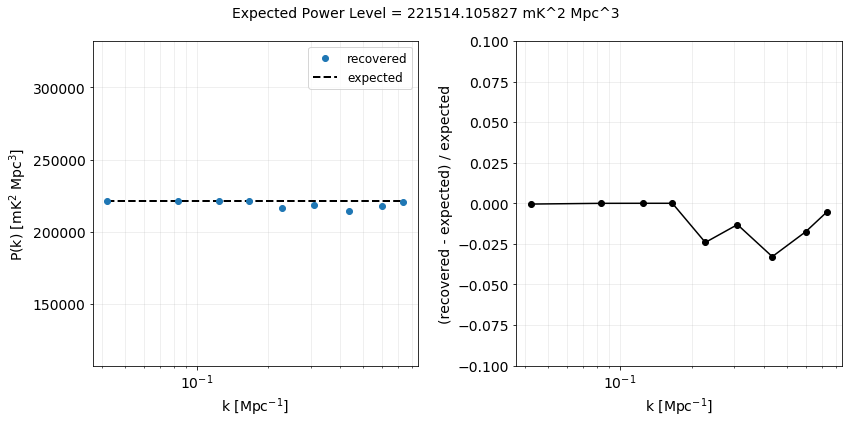

In [23]:
### STEP 1
"""
    Create the white noise sky realization:
    The dimensionless power spectrum (dmps) prior range in BayesEoR
    has currently been chosen to match the power level sigma**2 * dV
    of the healvis simulation in <HERA_data_path>.  The rms of the lmf
    cube used here will be scaled by the square root of the ratio of
    the pixel areas from the healvis simulation and the pixel area of
    the lmf cube to preserve the power spectrum.
"""
rms_mK = hv_sky_rms * np.sqrt(hv_pix_area_sr / dl_rad**2)

# Use the BayesEoR cosmology functions to calculate X2Y
cosmo = Cosmology()
redshift = cosmo.Convert_from_21cmFrequency_to_Redshift(freq_array_Hz.mean() / 1.0e6)
X2Y = cosmo.X2Y(redshift)
dV_Mpc3 = dV_sr_Hz * X2Y

# Calculate the expected power level in the lmf cube
# expected_power_lmf_cube = rms_mK**2 * X2Y * dV_sr_Hz
expected_power_lmf_cube = rms_mK**2 * X2Y * dV_sr_Hz
expected_power_hv = hv_sky_rms**2 * X2Y * hv_pix_area_sr * df_Hz
print('Expected Power Level:\n' + '-' * len('Expected Power Level:'))
print('sigma^2 * X2Y * dV = {} mK^2 Mpc^3'.format(expected_power_lmf_cube))


### STEP 2
k_vals = np.array(k_vals)
expected_dmps = expected_power_lmf_cube * k_vals**3 / (2 * np.pi**2)


### STEP 3
nsamples_per_kbin = np.array([k_cube_voxels_in_bin[i][0].size for i in range(nDims)])
var_a = np.zeros(len(k_vals))
for i_k in range(len(k_vals)):
    var_a[i_k] = (expected_dmps[i_k] / 
        PSPP_block_diag_Polychord.calc_dimensionless_power_spectral_normalisation_21cmFAST_v4d0(i_k).mean())

    
### STEP 4
recovered_ps = var_a / (dV_Mpc3 * (nf * ny * nx))
recovered_ps *= X2Y**2


### STEP 5
fig, axs = subplots(1, 2, figsize=(12, 6))
fontsize = 14

ax = axs[0]
ax.hlines(expected_power_lmf_cube, k_vals[0], k_vals[-1], linestyle='--', lw=2, color='k', label='expected')
ax.plot(k_vals, recovered_ps, linestyle='', marker='o', label='recovered')
cmin = np.min([expected_power_lmf_cube, recovered_ps.min()])
cmax = np.max([expected_power_lmf_cube, recovered_ps.max()])
ax.set_ylim([cmin / 2, cmax * 1.5])
ax.set_xscale('log')
# ax.set_yscale('log')
ax.grid(which='both', alpha=0.25)
ax.legend(loc='best')
ax.set_ylabel(r'P(k) [mK$^2$ Mpc$^3$]', fontsize=fontsize)

ax = axs[1]
frac_diff = (recovered_ps - expected_power_lmf_cube) / expected_power_lmf_cube
ax.plot(k_vals, frac_diff, 'o-', color='k')
ax.set_ylabel(r'(recovered - expected) / expected', fontsize=fontsize)
ax.set_xscale('log')
ax.set_ylim(-0.1, 0.1)
ax.grid(which='both', alpha=0.25)

for ax in axs:
    ax.tick_params(which='both', labelsize=fontsize)
    ax.set_xlabel(r'k [Mpc$^{-1}$]', fontsize=fontsize)

fig.tight_layout()
subplots_adjust(top=0.9, wspace=0.3)
fig.suptitle('Expected Power Level = {} mK^2 Mpc^3'.format(expected_power_lmf_cube), fontsize=fontsize);

**Figure 1** | (Left) The expected and recovered power spectra plotted as the dashed black line and blue points, respectively.  (Right) Fractional difference of the recovered power spectrum relative to the expedted power spectrum.

The recovered power spectrum appears to only mimic the expected power spectrum in the first four k-bins.  I think this is related to the fact that the way the normalization is set up in BayesEoR is a bit more sophisticated than the test I'm using here.  In detail, for each k-bin, the BayesEoR normalization calculates the normalization per |k| in the k-cube set up in BayesEoR and there are a number of $|k|$ within a k-bin (see the plot below for the number of $|k|$ within a k-bin).  So, the normalization actually spits out a normalization for each |k| within a k-bin and the same number of values of the variance of $\mathbf{a}$ at each $|k|$.  Here, I'm taking the mean of the normalization, i.e. the mean of the normalizations for all $|k|$ within that k-bin.  The recovered power spectrum only deviates from the expected power spectrum where the number of samples deviates from 96, i.e. in bins 4 - 8.  I haven't figured out in detail yet why this deviation in bins 4 - 8 is happening.

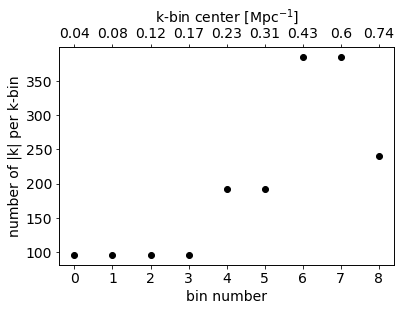

In [12]:
fig, ax = subplots(1, 1)

ax.plot(nsamples_per_kbin, 'ko')
ax.set_xticks(np.arange(nDims))
ax.set_xlabel('bin number', fontsize=fontsize)
ax.set_ylabel('number of |k| per k-bin', fontsize=fontsize)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(np.arange(nDims))
ax2.set_xticklabels(np.round(k_vals, decimals=2))
ax2.set_xlabel(r'k-bin center [Mpc$^{-1}$]', fontsize=fontsize)

for ax in fig.axes:
    ax.tick_params(which='both', labelsize=fontsize);

## BayesEoR Power Spectra

### Internal Model Tests

<a id="int_model"></a>
To test the new normalizations detailed in sections 3 and 4, I first ran a couple of runs using internally generated model visibilities.  To get this internal model dataset, the following steps were taken:

  1. Compute $\sigma$ for the starting sky model such that the power spectrum is conserved, i.e. $(\sigma^2\,\rm{d}V)_{BayesEoR} = (\sigma^2\,\rm{d}V)_{healvis}$.  This yields $\sigma = 0.8043383678108019\ \rm{mK}$ (computed in [Section 4.1](#ps_norm_test)).
  
  2. Generate a white noise sky cube $\mathbf{I}$ in units of $\rm{mK}$ with $(\mu, \sigma) = (0, 0.8043383678108019)$ and shape $(\rm{nf,\ ny,\ nx})$
  
  3. Compute model visibilities via $\mathbf{V} = \mathbf{F}^{-1}\,\mathbf{I}$
  
The parameters used in the power spectrum runs for the internal model visibilities were as follows:

| Parameter | Value | Units | Description
|:-- | :-- | :-- | :--
| $\rm{FoV}$   | 12.9080728652 | $\rm{deg}$ | Field of view
| $\rm{nx}$ = $\rm{ny}$ | 7, 9   |      -     | Number of pixels on a side in the uniform sky model
| $\rm{nu}$ = $\rm{nv}$ | 7, 9   |      -     | Number of pixels on a side in the uniform uv model
| Beam Type | Uniform | - | Beam used in instrument model
| $\rm{n}f$   | 38            |     -     | Number of frequency channels
| $f_{min}$   | 158304048.743 | $\rm{Hz}$ | Minimum frequency
| $\Delta f$  | 237618.986858 | $\rm{Hz}$ | Frequency channel width
| $\rm{nt}$       | 30 |      -     | Number of integrations (times)
| $\Delta \rm{t}$ | 30 | $\rm{sec}$ | Integration time

The commas in the table above for the value of $\rm{nx} = \rm{ny}$ is not intended to suggest that in one run $\rm{nx} \neq \rm{ny}$, but that two model resolutions were used in separate runs, being $\rm{nx} = 7$ and $9$.  

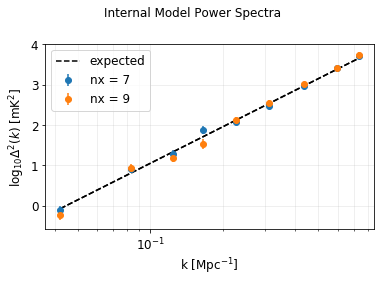

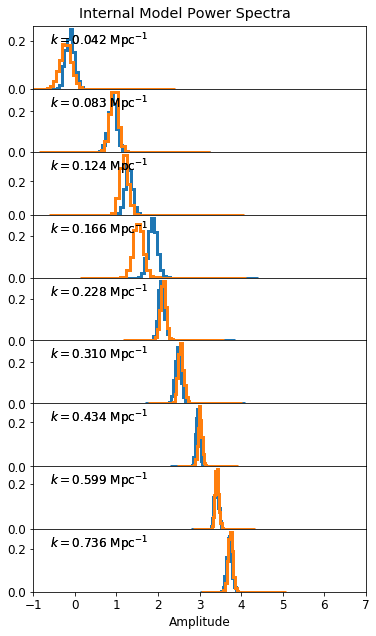

In [24]:
filenames = ['MN-EoR-7_7_38_0_2_s_2d6E-02-lp_T-dPS_T_b1_2.63_b2_2.82-v1-.txt',
             'MN-EoR-9_9_38_0_2_s_2d6E-02-lp_T-dPS_T_b1_2.63_b2_2.82-v2-.txt']
labels = ['nx = 7', 'nx = 9']
title_str = 'Internal Model Power Spectra'
single_plot = True

kurtoses, ulims, avgs, stddevs = plot_power_spectra(filenames, k_vals, dmps=True, labels=labels,
                                     title_str=title_str, use_kurtosis=True, return_kurtosis=True,
                                     top=0.85, single_plot=single_plot, expected_power=expected_power_hv)
plot_posteriors(filenames, k_vals, priors=[-1.0, 7.0], title_str=title_str, single_plot=single_plot)

**Figure 2** | (Top) Recovered power spectra for two different model resolutions, colors indicated in the legend, using internally generated model visibilities described in [Section 5.1](#int_model).  The errorbars plotted mark 1$\sigma$ errorbars.  (Bottom) Posteriors for the recovered power spectrum coefficients.  The posterior colors match the colors in the legend of the top plot.  There is a slight disagreement between the recovered power spectra at $k = 0.166$ Mpc$^{-1}$, in that they appear to disagree within 1$\sigma$ of one another.

### $\texttt{healvis}$ Simulated Datasets

I have also run several full tests with the above normalizations in place using simulated visibilities from $\texttt{healvis}$.  The $\texttt{healvis}$ simulations used were generated for the HERA-19 layout, with idealized antenna positions, using the following parameters:

| Parameter | Value | Units | Description
|:-- | :-- | :-- | :--
| $\rm{nside}$ | 32            |     -      | Determines the number of pixels and resolution of the healpix map ( $\rm{npix} = 12 \cdot nside^2$ )
| $\rm{FoV}$   | 12.9080728652 | $\rm{deg}$ | Field of view
| $\sigma$     | 0.00080949690 | $\rm{mK}$  | Standard deviation of the healpix sky model
| Beam Type    | Uniform       |     -      | Beam used in simulations
| $\rm{n}f$   | 38            |     -     | Number of frequency channels
| $f_{min}$   | 158304048.743 | $\rm{Hz}$ | Minimum frequency
| $\Delta f$  | 237618.986858 | $\rm{Hz}$ | Frequency channel width
| $\rm{nt}$       | 30 |      -     | Number of integrations (times)
| $\Delta \rm{t}$ | 30 | $\rm{sec}$ | Integration time

Five different sky realizations were used and thus five different datasets were generated.  These sky models and raw datasets can be found in
```
~/data/shared/bayeseor_files/healvis_comparison/white_noise_sky/Mar_16
```
and a yaml file containing all of the parameter values quoted in the table above can be found in `obsparams_uniform-beam_white-noise.yaml` inside the above directory.


The data need to be preprocessed before being passed to BayesEoR (the data needs to be reordered into a data vector ordered hierarchically by time --> frequency --> baseline).  These preprocessed datasets can be found in
```
~/data/shared/bayeseor_files/healvis_comparison/white_noise_sky/Mar_16/proc
```
The script used to generate these preprocessed datasets and a jupyter notebook showing how the script is called and used, for reference, can be found in
```
~/data/shared/bayeseor_files/healvis_comparison/scripts
```

**NOTE**: by default, healvis does not guarantee that the sky model generated is zero mean per frequency channel.  So, the sky models generated with healvis might not actually be zero mean.  I need to look into this (3/31/19).

### Internal Model and $\texttt{healvis}$ Visibilities Comparison

While the parameters in BayesEoR and $\texttt{healvis}$ have been chosen such that the internal model and $\texttt{healvis}$ visibilities are as similar as possible, there are some areas where the two sets of simulated data are not identical.  For example, some areas where these two datasets differ are in:

  1. The healvis sky changes with time, the BayesEoR model does not
  
  2. The pixel areas are slightly different, but they've been matched to be as close as possible
  
  3. The healvis sky model has a standard deviation that is scaled with frequency to keep the power spectrum flat

To first make a general comparison of the two datasets before diving into these discrepancies, the cells below compare their standard deviations and historgram the real and imaginary components of the two datasets to get a sense of what the visibilities look like statistically.

In [25]:
# healvis data
hv_data_path = '/users/jburba/data/shared/bayeseor_files/healvis_comparison/white_noise_sky/Mar_16/proc/'
hv_glob_filename = 'flatspec_eor_hera19_int30sec_uniform_nside32_fov12deg_rect_Mar16_?sky_uv.'\
                   'start_freq_159d0_Nbls_99_weighted_average_phased_flattened_30_times_mK_sr.npy'
hv_filepaths = sorted(glob.glob(os.path.join(hv_data_path, hv_glob_filename)))
nruns = len(hv_filepaths)

print('healvis Data:\n' + '-' * len('healvis Data:'))
print('Loading healvis data...')
hv_vis = []
for filepath in hv_filepaths:
    hv_vis.append(np.load(filepath))
hv_vis = np.array(hv_vis)
print('healvis data shape = {}'.format(hv_vis.shape))
print('healvis data std   = {} mK sr\n'.format(hv_vis.std(axis=1)))

# BayesEoR data
print('BayesEoR Data:\n' + '-' * len('BayesEoR Data:'))
print('Generating BayesEoR data...')
np.random.seed(12346)
print('white noise cube shape  = {}'.format((nf, ny, nx)))
beor_sky_model = np.random.normal(0, rms_mK, (nf, ny, nx))
for i_f in range(nf):
    beor_sky_model[i_f] -= beor_sky_model[i_f].mean()
print('RMS of white noise cube = {} mK'.format(beor_sky_model.std()))
beor_vis = np.dot(Finv, beor_sky_model.reshape(-1,1)).flatten()
print('BayesEoR data shape     = {}'.format(beor_vis.shape))
print('BayesEoR data std       = {}'.format(beor_vis.std()))

healvis Data:
-------------
Loading healvis data...
healvis data shape = (5, 20520)
healvis data std   = [0.00597799 0.00549442 0.00580076 0.00574748 0.00558583] mK sr

BayesEoR Data:
--------------
Generating BayesEoR data...
white noise cube shape  = (38, 7, 7)
RMS of white noise cube = 0.810936794356 mK
BayesEoR data shape     = (20520,)
BayesEoR data std       = 0.00589652294526


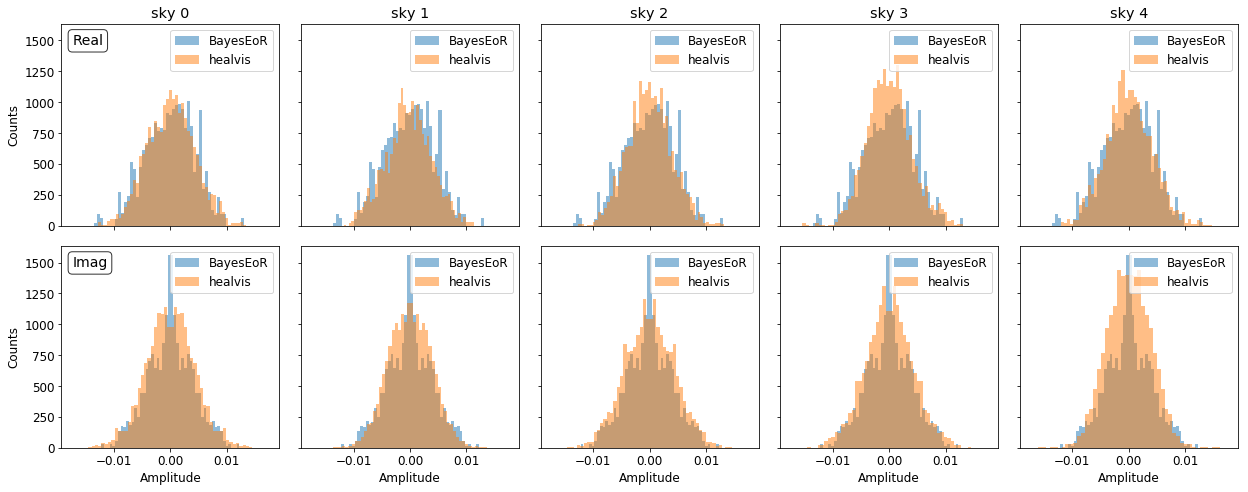

In [26]:
nrows = 2
ncols = nruns
plot_size = 3.5
fig, axs = subplots(nrows, ncols, figsize=(ncols * plot_size, nrows * plot_size), sharey=True, sharex=True)
xlims = [0, 0]
ylims = [0, 0]
axs = np.array(axs).T
props = dict(boxstyle='round', facecolor='white', alpha=0.8)

for i_col in range(ncols):    
    # plot histograms of real part
    ax = axs[i_col][0]
    ax.hist(beor_vis.real, bins=50, alpha=0.5, label='BayesEoR')
    ax.hist(hv_vis[i_col].real, bins=50, alpha=0.5, label='healvis')
    ax.legend(loc='upper right')
    ax.set_title('sky {}'.format(i_col))
    if i_col == 0:
        ax.set_ylabel('Counts')
        ax.text(0.05, 0.95, 'Real',transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    curr_xlim = ax.get_xlim()
        
    # plot histograms of imaginary part
    ax = axs[i_col][1]
    ax.hist(beor_vis.imag, bins=50, alpha=0.5, label='BayesEoR')
    ax.hist(hv_vis[i_col].imag, bins=50, alpha=0.5, label='healvis')
    ax.legend(loc='upper right')
    if i_col == 0:
        ax.set_ylabel('Counts')
        ax.text(0.05, 0.95, 'Imag', transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    ax.set_xlabel('Amplitude')

fig.tight_layout()
subplots_adjust(wspace=0.1, hspace=0.1)

**Figure 3** | Histograms comparing the real (top row) and imaginary (bottom row) components of the internal BayesEoR (blue) and healvis (orange) generated visibilities across five different healvis sky realizations (columns).

#### Time Evolution of the Sky Model

In $\texttt{healvis}$, the visibilities are generated for a drift scan observation, i.e. the sky model rotates above the observatory, which is always zenith pointing, as a function of time and as such pixels enter and leave the field of view of the instrument.  However, in BayesEoR, the instrument model is set up such that the instrument tracks the same patch of sky as it moves overhead, i.e. is phased to the center of the patch of sky for all times.  However, for a 15 minute observation, the sky only rotates about 3.75 degrees.  The side length of a healpix pixel for $\rm{nside} = $ {{nside}} is roughly {{np.round(np.rad2deg(np.sqrt(hv_pix_area_sr)), decimals=2)}} degrees.  This means that only ~ 2 new pixels will enter and ~2 other pixels will leave the fov over the course of one $\texttt{healvis}$ simulation.

#### Pixel Area Comparison

While the frequencies used in both BayesEoR and $\texttt{healvis}$ are identical, there are other areas where these two sets of simulated data differ.  For example, the pixel areas are close, but not exact.  And, the sky models generated will be different in terms of the values and spatial orientation of the pixels.  A comparison of some of these differences can be seen in the following cells.

For reference, the healvis pixel area is given by $4\,\pi\,(12\,\rm{nside}^2)^{-1}$.

In [27]:
# pixel area comparison
print('healvis nside       = {}'.format(nside))
print('healvis pixel area  = {} sr'.format(hv_pix_area_sr))
print('BayesEoR pixel area = {} sr'.format(dl_rad**2))
print('Pixel area fractional difference = {}'.format((dl_rad**2 - hv_pix_area_sr) / hv_pix_area_sr))

healvis nside       = 32
healvis pixel area  = 0.00102265385859 sr
BayesEoR pixel area = 0.00103581327289 sr
Pixel area fractional difference = 0.0128679065609


#### Sky Model Standard Deviation Comparison

In [28]:
hv_data_path = '/users/jburba/data/shared/bayeseor_files/healvis_comparison/white_noise_sky/Mar_16/'
hv_sky_model_filename = 'flatspec_std0.8mK_nside32_Mar16.hdf5'
hv_sky_models_mK = h5py.File(os.path.join(hv_data_path, hv_sky_model_filename), 'r')['data'][:] * 1.0e3
hv_freqs_Hz = h5py.File(os.path.join(hv_data_path, hv_sky_model_filename), 'r')['freqs'][:]
hv_sky_model_subset_filename = 'flatspec_std0.8mK_nside32_Mar16_subset.npy'
hv_sky_models_subset_mK = np.load(os.path.join(hv_data_path, hv_sky_model_subset_filename)) * 1.0e3

nruns, _, hv_nf = hv_sky_models_mK.shape

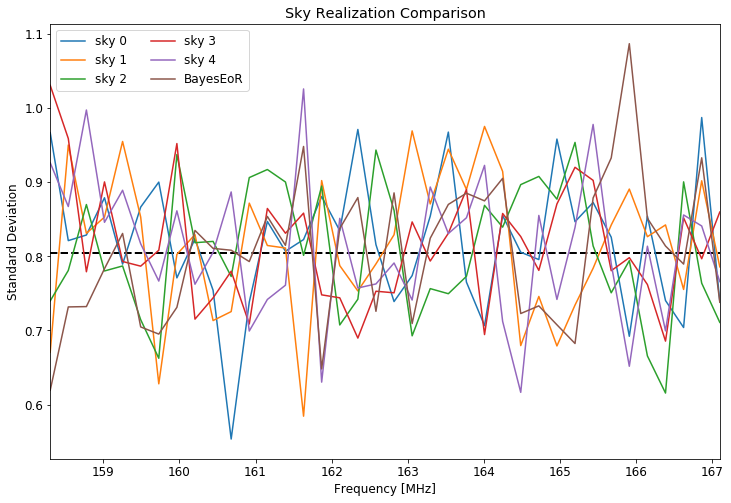

In [29]:
for i_run in range(nruns):
    plot(hv_freqs_Hz / 1.0e6, hv_sky_models_subset_mK[i_run].std(axis=0), label='sky {}'.format(i_run))
plot(hv_freqs_Hz / 1.0e6, beor_sky_model.std(axis=(1, 2)), label='BayesEoR')
xlabel('Frequency [MHz]')
ylabel('Standard Deviation')
title('Sky Realization Comparison')
legend(loc='best', ncol=2)
hlines(rms_mK, hv_freqs_Hz[0] / 1.0e6, hv_freqs_Hz[-1] / 1.0e6, linestyle='--', lw=2)
xlim([hv_freqs_Hz[0] / 1.0e6, hv_freqs_Hz[-1] / 1.0e6]);

**Figure 4** | Comparison of the standard deviation of a frequency slice of the $\texttt{healvis}$ sky models (colored lines, sky # in the legend) and the BayesEoR white noise sky model (brown line).  The dashed black line marks the desired RMS of {{rms_mK}} $\rm{mK}$.  Only the pixels included in the visibility calculation at the central time step of the healvis simulation are used in the calculation of the standard deviation in this plot.

It is worthwhile to note that the white noise sky generated in $\texttt{healvis}$ is scaled per frequency channel such that the power spectrum is flat.  Since the voxel volume is changing as a function of frequency, the standard deviation of the sky model is scaled relative to the 0th frequency channel such that the power spectrum ($\sigma^2\,\rm{d}V$) remains flat.  Thus, there is a slope to the standard deviation of the healvis sky model as  afunction of frequency.  This can be seen below in [Figure 5](#hv_std_slope).

When only using the pixels that are used in the visibility calculation, i.e. those pixels that fall within the rectangular region within $\pm\rm{FoV}/2$ of the pointing center.

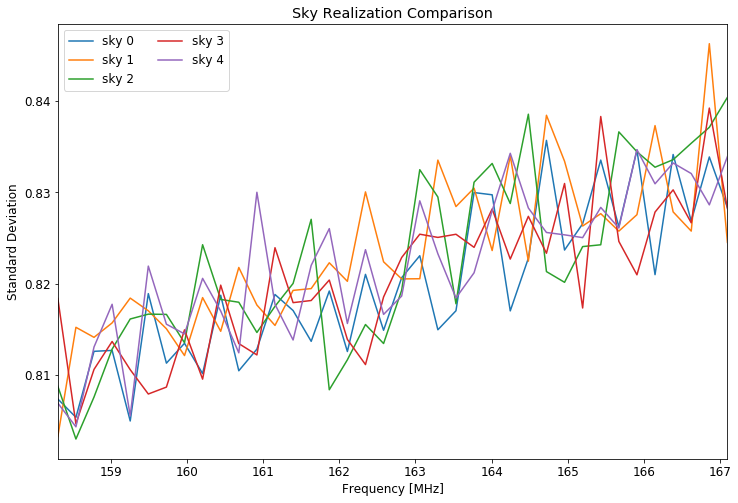

In [30]:
hv_sky_models_stds_mK = hv_sky_models_mK.std(axis=(1))
frac_diffs = np.zeros(nruns)
for i_run in range(nruns):
    frac_diffs[i_run] = ((hv_sky_models_stds_mK[i_run, -1]
                          -
                          hv_sky_models_stds_mK[i_run, 0])
                          /
                          hv_sky_models_stds_mK[i_run, 0])
    plot(hv_freqs_Hz / 1.0e6, hv_sky_models_stds_mK[i_run], label='sky {}'.format(i_run))
xlabel('Frequency [MHz]')
ylabel('Standard Deviation')
title('Sky Realization Comparison')
legend(loc='best', ncol=2)
xlim([hv_freqs_Hz[0] / 1.0e6, hv_freqs_Hz[-1] / 1.0e6]);

<a id="hv_std_slope"></a>
**Figure 5** | Standard deviation of all pixels within a frequency slice of a healvis sky realization.  The slope in the standard deviation due to the change in volume scaling is relatively small, changing by at most {{np.round(frac_diffs.max() * 100.0, decimals=2)}}% across the band.

### BayesEoR Power Spectrum Tests
The model parameters in BayesEoR were chosen to be identical or as close as possible to those used in the healvis simulations

| Parameter | Value | Units | Description
|:-- | :-- | :-- | :--
| $\rm{FoV}$   | 12.9080728652 | $\rm{deg}$ | Field of view
| $\rm{nx}$, $\rm{ny}$ | 7   |      -     | Number of pixels on a side in the uniform sky model
| $\rm{nu}$, $\rm{nv}$ | 7   |      -     | Number of pixels on a side in the uniform uv model
| Beam Type | Uniform | - | Beam used in instrument model
| $\rm{n}f$   | 38            |     -     | Number of frequency channels
| $f_{min}$   | 158304048.743 | $\rm{Hz}$ | Minimum frequency
| $\Delta f$  | 237618.986858 | $\rm{Hz}$ | Frequency channel width
| $\rm{nt}$       | 30 |      -     | Number of integrations (times)
| $\Delta \rm{t}$ | 30 | $\rm{sec}$ | Integration time

The noise added to the simulated data vector (in units of $\rm{mK\ sr}$) in BayesEoR was chosen to be $0.3 * \rm{data.std()}$, using the data from the 0th sky realization, and has a numerical value of $0.001555210668254031 \rm{ mK\ sr}$, for reference.

These BayesEoR power spectrum tests can be broken down into two different categories:
  
  1. Different sky noise seeds: compute power spectra for each, unique sky realization  

  2. Different BayesEoR sky model resolutions: vary $\rm{nx}$, the number of pixels on a side in the BayesEoR sky model but keep the $\rm{FoV}$ fixed
  


#### Different Sky Noise Seeds

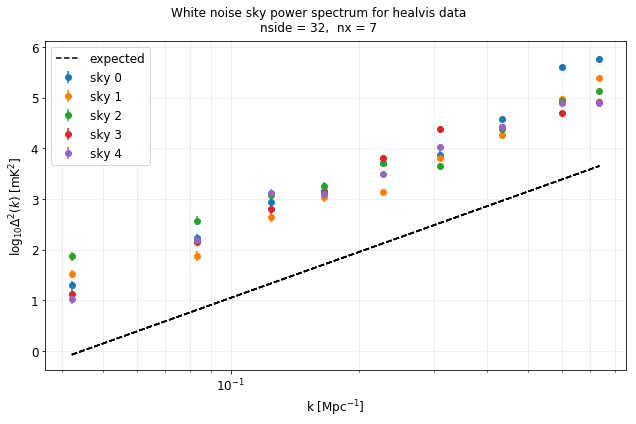

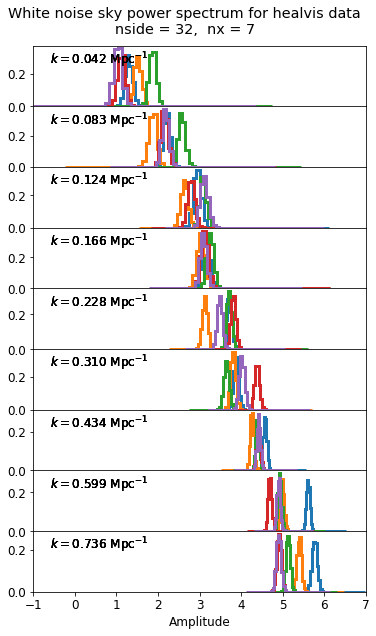

In [31]:
chains_path = '/users/jburba/data/jburba/bayes/BayesEoR/chains/'
filenames = ['MN-Test-7_7_38_0_2_s_2d6E-02-lp_T-dPS_T_b1_2.63_b2_2.82-v1-.txt',
             'MN-Test-7_7_38_0_2_s_2d6E-02-lp_T-dPS_T_b1_2.63_b2_2.82-v2-.txt',
             'MN-Test-7_7_38_0_2_s_2d6E-02-lp_T-dPS_T_b1_2.63_b2_2.82-v3-.txt',
             'MN-Test-7_7_38_0_2_s_2d6E-02-lp_T-dPS_T_b1_2.63_b2_2.82-v4-.txt',
             'MN-Test-7_7_38_0_2_s_2d6E-02-lp_T-dPS_T_b1_2.63_b2_2.82-v5-.txt']


labels = ['sky 0', 'sky 1', 'sky 2', 'sky 3', 'sky 4']
title_str = 'White noise sky power spectrum for healvis data\nnside = 32,  nx = 7'
single_plot = True

kurtoses, ulims, avgs, stddevs = plot_power_spectra(filenames, k_vals, dmps=True, labels=labels,
                                     title_str=title_str, use_kurtosis=True, return_kurtosis=True,
                                     top=0.9, single_plot=single_plot, expected_power=expected_power_hv,
                                     figsize=(9, 6), prefix=chains_path)
plot_posteriors(filenames, k_vals, priors=[-1.0, 7.0], title_str=title_str, single_plot=single_plot, top=0.92,
                prefix=chains_path)

<a id="fig_6"></a>
**Figure 6** | (Top) Recovered power spectra from BayesEoR for five different sky realizations (colored data points with errorbars) with the expected power level $P(k) = \sigma^2 \, X^2Y \, \rm{d}V$ plotted as the dashed black line.  (Bottom) Posteriors for the power spectrum coefficients.  The colors of the posteriors match the legend in the top power spectrum plot.  Clearly, there is a significant offset of the recovered power spectra from the expected power level.

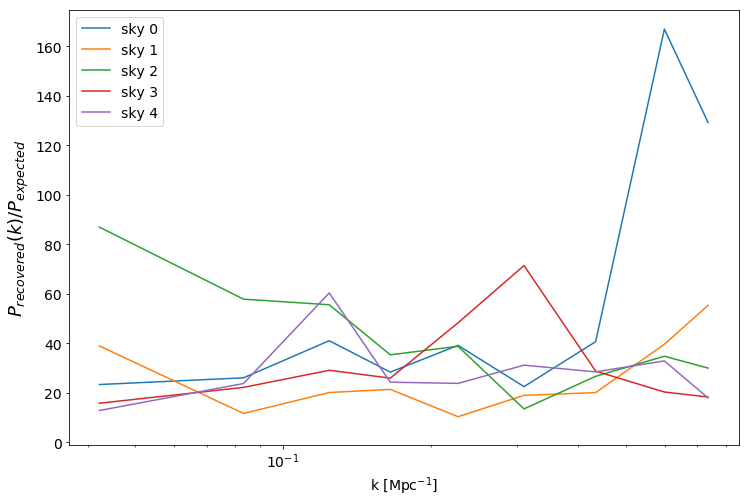

In [32]:
fontsize = 14

fig = figure(figsize=(12, 8))
expected_log_dmps = np.log10(expected_power_hv * k_vals**3 / (2 * np.pi**2))
ratios = np.zeros((len(filenames), len(k_vals)))
for i_file in range(len(filenames)):
    ratios[i_file] = 10**avgs[i_file] / 10**expected_log_dmps
    plot(k_vals, ratios[i_file], label=labels[i_file])
xscale('log')
legend(loc='best', fontsize=fontsize)
xlabel(r'k [Mpc$^{-1}$]', fontsize=fontsize)
ylabel(r'$P_{recovered}(k) / P_{expected}$', fontsize=18)
tick_params(which='both', labelsize=fontsize)
ylim([-1, gca().get_ylim()[1]]);

**Figure 7** | Ratio in linear units of each recovered power spectrum to the expected power spectrum.  The recovered power spectra are at least an order of magnitude larger than the expected power level.

For reference, the fitted slopes of each of the recovered power spectra in [Figure 6](#fig_6) can be seen below.  If they have the right shape, their slopes should be consistent with 3.0.  The printed errorbars are approximately one sigma errorbars from the $\texttt{np.polyfit}$ function.

In [33]:
# fit power spectra with a line in log-log space, should have slope = 3.0
for i_file, fn in enumerate(filenames):
    fitcoeffs, fitcov = np.polyfit(log_k_vals, avgs[i_file], 1, cov=True)
    print('{}:\n'.format(fn) + '-' * len(fn+':'))
    print('Fitted slope = {} +/- {} mK^2 / Mpc^-1\n\n'.format(fitcoeffs[0], np.sqrt(fitcov[0, 0])))

MN-Test-7_7_38_0_2_s_2d6E-02-lp_T-dPS_T_b1_2.63_b2_2.82-v1-.txt:
----------------------------------------------------------------
Fitted slope = 3.58638247269 +/- 0.197710198243 mK^2 / Mpc^-1


MN-Test-7_7_38_0_2_s_2d6E-02-lp_T-dPS_T_b1_2.63_b2_2.82-v2-.txt:
----------------------------------------------------------------
Fitted slope = 3.19732408639 +/- 0.212824223118 mK^2 / Mpc^-1


MN-Test-7_7_38_0_2_s_2d6E-02-lp_T-dPS_T_b1_2.63_b2_2.82-v3-.txt:
----------------------------------------------------------------
Fitted slope = 2.59535457387 +/- 0.145503569584 mK^2 / Mpc^-1


MN-Test-7_7_38_0_2_s_2d6E-02-lp_T-dPS_T_b1_2.63_b2_2.82-v4-.txt:
----------------------------------------------------------------
Fitted slope = 3.10841385834 +/- 0.192052661469 mK^2 / Mpc^-1


MN-Test-7_7_38_0_2_s_2d6E-02-lp_T-dPS_T_b1_2.63_b2_2.82-v5-.txt:
----------------------------------------------------------------
Fitted slope = 3.10949978912 +/- 0.170582060041 mK^2 / Mpc^-1




#### Different BayesEoR Sky Model Resolutions

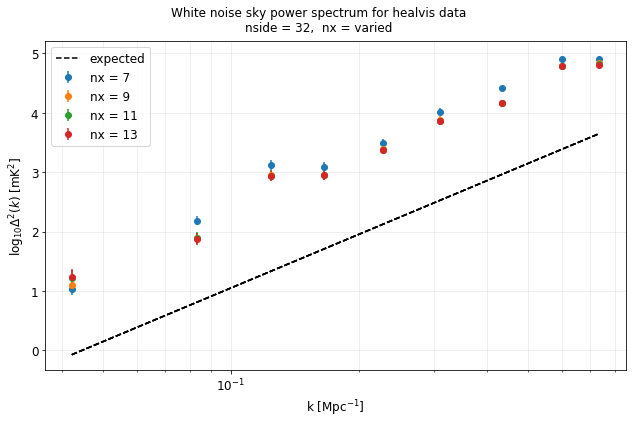

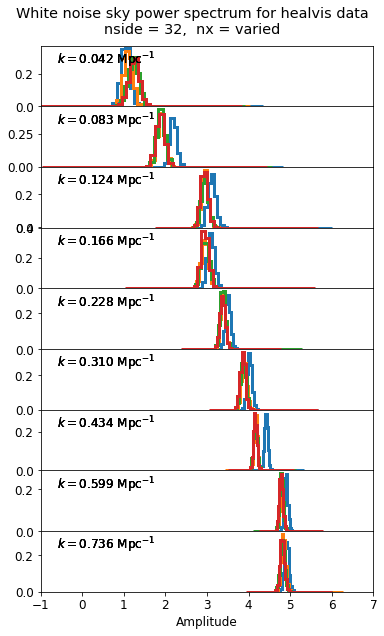

In [34]:
chains_path = '/users/jburba/data/jburba/bayes/BayesEoR/chains/'
filenames = ['MN-Test-7_7_38_0_2_s_2d6E-02-lp_T-dPS_T_b1_2.63_b2_2.82-v5-.txt',
             'MN-Test-9_9_38_0_2_s_2d6E-02-lp_T-dPS_T_b1_2.63_b2_2.82-v8-.txt',
             'MN-Test-11_11_38_0_2_s_2d6E-02-lp_T-dPS_T_b1_2.63_b2_2.82-v1-.txt',
             'MN-Test-13_13_38_0_2_s_2d6E-02-lp_T-dPS_T_b1_2.63_b2_2.82-v1-.txt']
labels = ['nx = 7', 'nx = 9', 'nx = 11', 'nx = 13']
title_str = 'White noise sky power spectrum for healvis data\nnside = 32,  nx = varied'
single_plot = True

kurtoses, ulims, avgs, stddevs = plot_power_spectra(filenames, k_vals, dmps=True, labels=labels,
                                     title_str=title_str, use_kurtosis=True, return_kurtosis=True,
                                     top=0.9, single_plot=single_plot, expected_power=expected_power_hv,
                                     figsize=(9, 6), prefix=chains_path)
plot_posteriors(filenames, k_vals, priors=[-1.0, 7.0], title_str=title_str, single_plot=single_plot, top=0.92,
                prefix=chains_path)

<a id="fig_8"></a>
**Figure 8** | (Top) Recovered power spectra from BayesEoR for four different BayesEoR model resolutions (colored data points with errorbars) with the expected power level $P(k) = \sigma^2 \, X^2Y \, \rm{d}V$ plotted as the dashed black line.  (Bottom) Posteriors for the power spectrum coefficients.  The colors of the posteriors match the legend in the top power spectrum plot.  Clearly, there is a significant offset of the recovered power spectra from the expected power level.

Mean ratio values for each nx = [28.51737755 20.20125123 20.70502316 20.44719177]


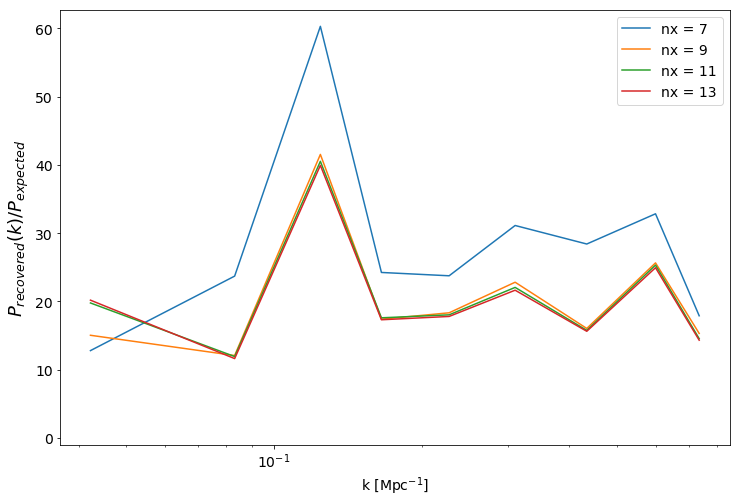

In [39]:
fontsize = 14

fig = figure(figsize=(12, 8))
expected_log_dmps = np.log10(expected_power_hv * k_vals**3 / (2 * np.pi**2))
ratios = np.zeros((len(filenames), len(k_vals)))
for i_file in range(len(filenames)):
    ratios[i_file] = 10**avgs[i_file] / 10**expected_log_dmps
    plot(k_vals, ratios[i_file], label=labels[i_file])
xscale('log')
legend(loc='best', fontsize=fontsize)
xlabel(r'k [Mpc$^{-1}$]', fontsize=fontsize)
ylabel(r'$P_{recovered}(k) / P_{expected}$', fontsize=18)
tick_params(which='both', labelsize=fontsize)
ylim([-1, gca().get_ylim()[1]])
print('Mean ratio values for each nx = {}'.format(np.average(ratios, weights=stddevs, axis=1)))

**Figure 9** | Ratio in linear units of each recovered power spectrum to the expected power spectrum.  The recovered power spectra are at least an order of magnitude larger than the expected power level.

It's interesting here that the recovered power spectra, at least for $\rm{nx} \geq 9$, are clustered and have a mean ratio value of $\sim$20.  This offset is close to $2 \pi^2 = 19.739208802178716$ or to $\rm{nf} / 2 = 19$, but I don't think that either of these factors should pop up in the power spectrum of matrix normalizations.  There's already a factor of $(2\pi^2)^{-1}$ in the power spectrum normalization, since $\Delta^2(k) = k^3 (2\pi^2)^{-1} P(k)$, but I have no idea why there would be another factor of $2\pi^2$.  Both of these potential corrections are still a bit shy of the actual mean ratio for each resolution, though.